<a href="https://colab.research.google.com/github/gommungommun/VCD/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


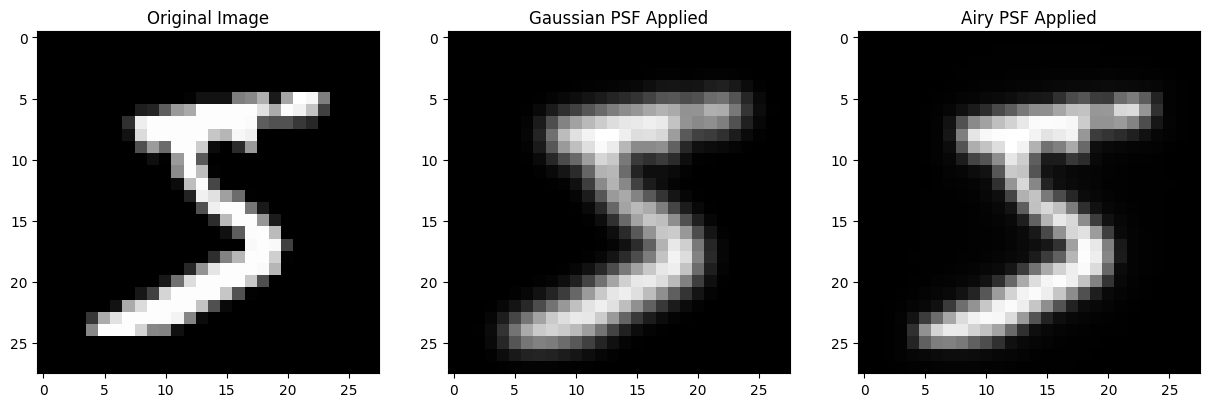

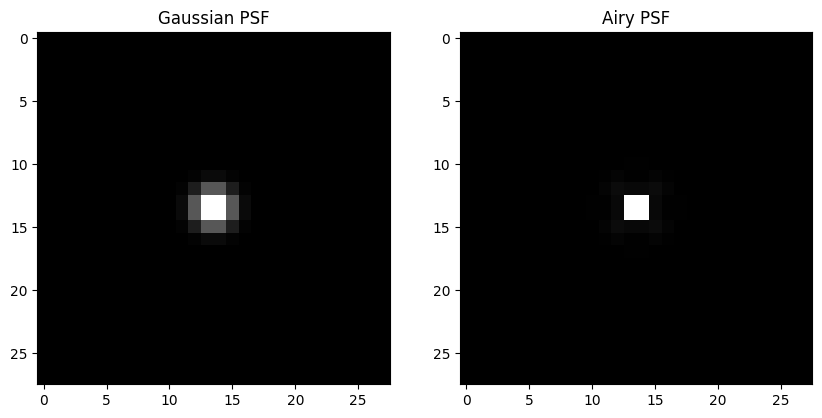

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy import special
from scipy.signal import convolve2d
from tensorflow.keras.datasets import mnist

# MNIST 데이터 로드
(x_train, _), (_, _) = mnist.load_data()

# 테스트할 이미지 선택 (예: 첫 번째 이미지)
test_image = x_train[0]

# PSF 함수들 (위에서 정의한 함수들 사용)
def gaussian_psf(size=64, sigma=3):
    x = np.linspace(-size/2, size/2, size)
    y = np.linspace(-size/2, size/2, size)
    x, y = np.meshgrid(x,y)

    pos = np.dstack((x,y))
    rv = multivariate_normal([0,0],[[sigma**2,0],[0,sigma**2]])
    psf = rv.pdf(pos)

    return psf/psf.sum()

def airy_psf(size=64, na=0.65,wavelength=550e-9):
    x = np.linspace(-size/2, size/2, size)
    y = np.linspace(-size/2, size/2, size)
    x, y = np.meshgrid(x, y)

    r = np.sqrt(x**2+y**2)
    k = 2*np.pi*na/wavelength

    psf = np.zeros_like(r)
    mask = r!=0
    psf[mask] = (2*special.j1(k*r[mask])/(k*r[mask]))**2
    psf[~mask] = 1

    return psf/psf.sum()

# PSF 생성
gaussian_filter = gaussian_psf(size=28, sigma=1)  # MNIST 이미지 크기에 맞춰 size=28
airy_filter = airy_psf(size=28)

# 필터 적용
gaussian_result = convolve2d(test_image, gaussian_filter, mode='same')
airy_result = convolve2d(test_image, airy_filter, mode='same')

# 결과 시각화
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image')

plt.subplot(132)
plt.imshow(gaussian_result, cmap='gray')
plt.title('Gaussian PSF Applied')

plt.subplot(133)
plt.imshow(airy_result, cmap='gray')
plt.title('Airy PSF Applied')

plt.show()

# 필터 시각화
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(gaussian_filter, cmap='gray')
plt.title('Gaussian PSF')

plt.subplot(122)
plt.imshow(airy_filter, cmap='gray')
plt.title('Airy PSF')

plt.show()